In [26]:
import numpy as np
import matplotlib.pyplot as plt

In [33]:
# Function to sample points on a plane
def sample_points_on_plane(plane_point, plane_normal, num_points, plane_size=10):
    # Generate two random vectors in the plane
    # Create two orthogonal vectors to the normal
    v1 = np.random.rand(3)
    v1 -= v1.dot(plane_normal) * plane_normal  # Make it orthogonal to the plane normal
    v1 /= np.linalg.norm(v1)  # Normalize

    v2 = np.cross(plane_normal, v1)  # v2 is perpendicular to both the normal and v1

    # Generate random points on the plane
    u = np.random.uniform(-plane_size, plane_size, num_points)
    v = np.random.uniform(-plane_size, plane_size, num_points)
    points = plane_point + u[:, None] * v1 + v[:, None] * v2
    
    # Add noise relative to the normal of the plane
    noise = np.random.normal(loc=0, scale=5, size=(num_points, 3))
    noise_magnitude = np.random.exponential(0.1, num_points)
    noise *= noise_magnitude[:, None]
    points += noise
    
    return points

# Define planes (each plane has a point and a normal vector)
planes = [
    {"point": np.array([0, 0, 10]), "normal": np.array([0.0, 0, 1])},  # A plane perpendicular to Z
    {"point": np.array([5, 0, -10]), "normal": np.array([1.0, 1, 0]) / np.sqrt(2)},  # A tilted plane
    {"point": np.array([0, -5, -8]), "normal": np.array([0.0, 1, 1])},  # A plane perpendicular to Y
]

# Number of points to sample per plane
num_points_per_plane = 1000

# Generate points for each plane
all_points = []
for plane in planes:
    normal = plane["normal"]
    normal /= np.linalg.norm(normal)
    points = sample_points_on_plane(plane["point"], normal, num_points_per_plane)
    all_points.append(points)

# Combine all points
point_cloud = np.vstack(all_points)

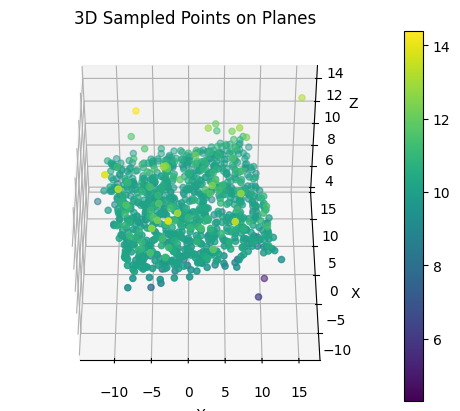

In [34]:
# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Extract the x, y, z coordinates from the point cloud
x = point_cloud[:, 0]
y = point_cloud[:, 1]
z = point_cloud[:, 2]

# Plot the point cloud
sc = ax.scatter(x, y, z, c=z, cmap='viridis', marker='o')

# Adjust view so that Z axis points to the right
ax.view_init(elev=45, azim=-90)

# Set axis labels
ax.set_xlabel('Y')  # Y now points up
ax.set_ylabel('X')  # X is now forward
ax.set_zlabel('Z')  # Z points to the right

# Set the title of the plot
ax.set_title('3D Sampled Points on Planes')

# Show color bar for depth (z-axis values)
plt.colorbar(sc)

# Show the plot
plt.show()

In [35]:
# Save the point cloud to a file
np.savetxt("multiple_plane.txt", point_cloud)

In [30]:
from prosac import ransac, Model, prosac


# Define a plane model
class PlaneModel(Model):
    def __init__(self):
        self.p = None
        self.n = None
        
    def fit(self, pts):
        # Fit a plane to the points
        centroid = np.mean(pts, axis=0)
        pts_centered = pts - centroid
        _, _, V = np.linalg.svd(pts_centered)
        normal = V[-1]
        normal /= np.linalg.norm(normal)
        
        self.p = centroid
        self.n = normal
        
    def predict(self, data):
        return data
        
    def error(self, x):
        # Calculate the distance between a point x and the plane
        return np.abs(np.dot(x - self.p, self.n))
    
    @staticmethod
    def get_complexity():
        return 3
    
    def __repr__(self):
        return f"PlaneModel(p={self.p}, n={self.n})"

print(point_cloud.shape)
subset = np.copy(point_cloud)
pred_planes = []
for i in range(3):
    # Remove inliers from the subset
    plane = ransac(subset, PlaneModel, 5, 0.99)
    pred_planes.append(plane)
    
    error = plane.error(subset)
    to_remove = error < 5
    subset = subset[~to_remove]

(3000, 3)
